# Energy Threshold Handling for Stacking Datasets

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import copy

In [2]:
from gammapy.spectrum import SpectrumDataset, CountsSpectrum
from gammapy.irf import EffectiveAreaTable, EDispKernel
from gammapy.maps import MapAxis
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel

In [3]:
energy_true = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=20, per_decade=True)
energy_reco = MapAxis.from_energy_bounds("0.2 TeV", "30 TeV", nbin=10, per_decade=True)

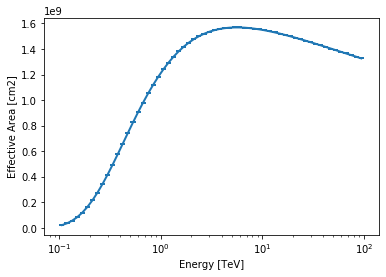

In [4]:
aeff = EffectiveAreaTable.from_parametrization(energy=energy_true.edges, instrument="HESS")
aeff.plot()

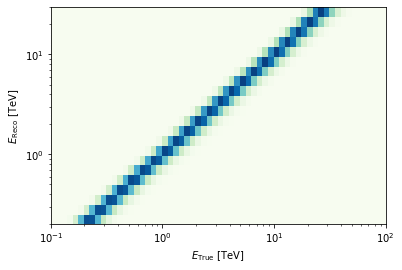

In [5]:
edisp = EDispKernel.from_gauss(e_reco=energy_reco.edges, e_true=energy_true.edges, sigma=0.1, bias=0)
edisp.plot_matrix()

In [6]:
pwl = PowerLawSpectralModel()
model = SkyModel(spectral_model=pwl, name="test-source")

In [7]:
e_min_1 = 2 * u.TeV

aeff_1 = copy.deepcopy(aeff)
aeff_1.data.data *= np.power((aeff.energy.center / (1 * u.TeV)), 0.5)

dataset_1 = SpectrumDataset(
    models=[model],
    aeff=aeff_1,
    edisp=edisp,
    mask_safe=(energy_reco.center > e_min_1),
    livetime=1 * u.h
)
dataset_1.counts = dataset_1.npred()

In [8]:
e_min_2 = 0.6 * u.TeV
dataset_2 = SpectrumDataset(
    models=[model],
    aeff=aeff,
    edisp=edisp,
    mask_safe=(energy_reco.center > e_min_2),
    livetime=1 * u.h
)
dataset_2.counts = dataset_2.npred()

In [9]:
stacked = dataset_1.copy(name="stacked")
stacked.stack(dataset_2)

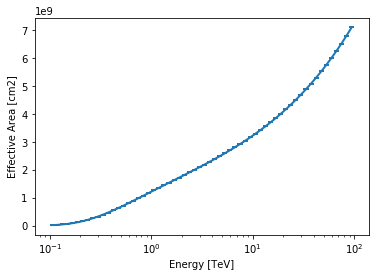

In [10]:
stacked.aeff.plot()

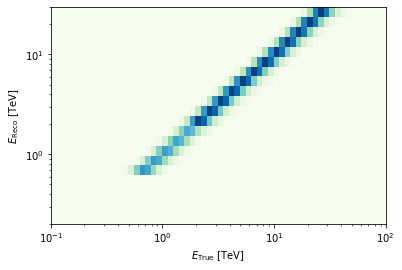

In [11]:
stacked.edisp.plot_matrix()

In [12]:
stacked.models = model

In [13]:
npred_stacked = stacked.npred()

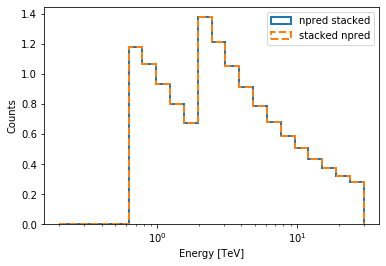

In [15]:
npred_stacked.plot_hist(label="npred stacked")
stacked.counts.plot_hist(ls="--", label="stacked npred")
plt.legend()